
# ✅ Final UCF101 Action Recognition — Local Windows Training
**Stack:** Keras 3 (Torch backend) + YOLOv8 Pose (GPU) — No CUDA installs needed.

This notebook:
- Loads UCF101 from a **local path** (you extracted manually).
- Extracts **pose keypoints** using **YOLOv8 Pose** and **caches** them to disk.
- Trains the **Predictive Completion + Micro-Movement + Context Fusion** model.
- Uses **EarlyStopping** and **ModelCheckpoint** to save the **best model**.
- Generates **confusion matrix** and **classification report** on validation set.


In [13]:

# ==========================================================
# Backend & GPU checks — run this first
# ==========================================================
import os
os.environ["KERAS_BACKEND"] = "torch"  # must be set before importing keras

import keras, torch
print("Keras backend:", keras.config.backend())
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
else:
    print("⚠️ CUDA not available. Install torch with CUDA 12.1 wheels for GPU acceleration:")
    print("pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")


Keras backend: torch
Torch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


### Requirements used

In [14]:

from dataclasses import dataclass
import os

@dataclass
class Config:
    DATA_ROOT: str = r"C:\Users\mahes\Rvu-Python\FDL\Project\UCF-101"   # <-- CHANGE THIS to your local UCF101 root
    CACHE_DIR: str = "./cache_ucf101_yolo"
    SEQ_LEN: int = 32
    IMG_SIZE: int = 224
    J: int = 17          # YOLOv8 pose joints
    N_CLASSES: int = 101 # change if you subset classes
    MAX_VIDS_PER_CLASS: int | None = None  # e.g., 30 for quick experiment, None for all
    BATCH_SIZE: int = 8
    EPOCHS: int = 25
    LR: float = 1e-4
    PATIENCE: int = 5    # EarlyStopping patience
    NUM_WORKERS: int = 0 # Keras Sequence uses numpy; no torch workers here

cfg = Config()
os.makedirs(cfg.CACHE_DIR, exist_ok=True)
cfg


Config(DATA_ROOT='C:\\Users\\mahes\\Rvu-Python\\FDL\\Project\\UCF-101', CACHE_DIR='./cache_ucf101_yolo', SEQ_LEN=32, IMG_SIZE=224, J=17, N_CLASSES=101, MAX_VIDS_PER_CLASS=None, BATCH_SIZE=8, EPOCHS=25, LR=0.0001, PATIENCE=5, NUM_WORKERS=0)

## 1) Dataset: scan your local UCF101 path

In [15]:

import os, glob

def scan_ucf101(root, exts=('.avi', '.mp4', '.mov'), limit_per_class=None):
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    class_to_idx = {c:i for i,c in enumerate(classes)}
    items = []
    for c in classes:
        vids = []
        for e in exts:
            vids.extend(glob.glob(os.path.join(root, c, f"*{e}")))
        vids = sorted(vids)
        if limit_per_class:
            vids = vids[:limit_per_class]
        items.extend((v, class_to_idx[c]) for v in vids)
    return items, classes

items, classes = scan_ucf101(cfg.DATA_ROOT, limit_per_class=cfg.MAX_VIDS_PER_CLASS)
print("Classes:", len(classes))
print("Total videos found:", len(items))
print("Sample:", items[:3])


Classes: 101
Total videos found: 13320
Sample: [('C:\\Users\\mahes\\Rvu-Python\\FDL\\Project\\UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c01.avi', 0), ('C:\\Users\\mahes\\Rvu-Python\\FDL\\Project\\UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c02.avi', 0), ('C:\\Users\\mahes\\Rvu-Python\\FDL\\Project\\UCF-101\\ApplyEyeMakeup\\v_ApplyEyeMakeup_g01_c03.avi', 0)]


In [16]:

import random
random.seed(42)
random.shuffle(items)
n = len(items)
split = int(0.9*n)  # 90/10
train_items, val_items = items[:split], items[split:]
print(f"Train videos: {len(train_items)} | Val videos: {len(val_items)}")


Train videos: 11988 | Val videos: 1332


## 2) Video loading and frame sampling

In [17]:

import cv2
import numpy as np

def load_video_center_crop(path, T=32, img_size=224):
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    if total <= 0:
        # create T black frames
        frames = [np.zeros((img_size,img_size,3), dtype=np.uint8) for _ in range(T)]
        return np.stack(frames, 0)

    idxs = np.linspace(0, total-1, T).astype(int)
    frames = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, f = cap.read()
        if not ok or f is None:
            f = np.zeros((img_size,img_size,3), dtype=np.uint8)
        else:
            h, w = f.shape[:2]
            m = min(h, w)
            cy, cx = h//2, w//2
            y1, y2 = max(0, cy-m//2), min(h, cy+m//2)
            x1, x2 = max(0, cx-m//2), min(w, cx+m//2)
            f = f[y1:y2, x1:x2]
            try:
                f = cv2.resize(f, (img_size, img_size))
                f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
            except:
                f = np.zeros((img_size,img_size,3), dtype=np.uint8)
        frames.append(f)
    cap.release()
    return np.asarray(frames, dtype=np.uint8)  # (T,H,W,3)


## 3) YOLOv8-Pose extraction and caching

In [18]:

from ultralytics import YOLO

pose_model = YOLO('yolov8n-pose.pt')  # auto-downloads
DEVICE = 0 if torch.cuda.is_available() else 'cpu'

def extract_pose_yolo(frames, J=17):
    T = len(frames)
    coords = np.zeros((T, J, 2), dtype=np.float32)
    for t, f in enumerate(frames):
        try:
            r = pose_model.predict(f, device=DEVICE, verbose=False)
            if len(r) > 0 and getattr(r[0], "keypoints", None) is not None and r[0].keypoints is not None:
                pts_all = r[0].keypoints.xy
                if pts_all is not None and len(pts_all) > 0:
                    pts = pts_all[0].cpu().numpy()
                    if pts.shape[0] >= J:
                        coords[t] = pts[:J]
                    else:
                        pad = np.zeros((J,2), dtype=np.float32)
                        pad[:pts.shape[0]] = pts
                        coords[t] = pad
        except Exception as e:
            # keep zeros for this frame
            pass
    # Normalize per-frame: zero-mean, unit-std (avoid zero division)
    mean = coords.mean(axis=1, keepdims=True)
    std = coords.std(axis=1, keepdims=True) + 1e-6
    coords = (coords - mean) / std
    return coords  # (T,J,2)


In [19]:

import hashlib, os

def cache_key(video_path):
    return hashlib.md5(video_path.encode('utf-8')).hexdigest()

def get_keypoints_cached(video_path, T=32, img_size=224, J=17, cache_dir=cfg.CACHE_DIR):
    key = cache_key(video_path)
    npz_path = os.path.join(cache_dir, f"{key}.npz")
    if os.path.exists(npz_path):
        try:
            data = np.load(npz_path)
            coords, frame_center = data["coords"], data["frame_center"]
            if coords.shape != (T,J,2) or frame_center.shape != (img_size,img_size,3):
                raise ValueError("Shape mismatch in cache — will recompute")
            return coords, frame_center
        except Exception as e:
            try:
                os.remove(npz_path)
            except: pass
    # Compute
    frames = load_video_center_crop(video_path, T=T, img_size=img_size)
    coords = extract_pose_yolo(frames, J=J)
    # robust shapes
    if coords.shape != (T,J,2):
        fixed = np.zeros((T,J,2), dtype=np.float32)
        tmin = min(T, coords.shape[0]); jmin = min(J, coords.shape[1]); dmin = min(2, coords.shape[2])
        fixed[:tmin,:jmin,:dmin] = coords[:tmin,:jmin,:dmin]
        coords = fixed
    frame_center = frames[T//2].astype(np.float32) / 255.0
    np.savez_compressed(npz_path, coords=coords, frame_center=frame_center)
    return coords, frame_center


## 4) Keras Sequence loader

In [20]:

import keras
import numpy as np

class UCFSequence(keras.utils.Sequence):
    def __init__(self, items, batch_size, cfg, shuffle=True):
        super().__init__()
        self.items = items
        self.batch_size = batch_size
        self.cfg = cfg
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.items))
        self.on_epoch_end()

    def __len__(self):
        return (len(self.items) + self.batch_size - 1) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch = self.items[idx*self.batch_size : (idx+1)*self.batch_size]
        coords_list, img_list, label_list = [], [], []
    
        for path, label in batch:
            coords, img = get_keypoints_cached(path, T=cfg.SEQ_LEN, img_size=cfg.IMG_SIZE, J=cfg.J)
            coords_list.append(coords.reshape(cfg.SEQ_LEN, cfg.J*2))
            img_list.append(img)
            label_list.append(label)
    
        X = {
            "coords_in": np.array(coords_list, dtype="float32"),
            "img_in":    np.array(img_list, dtype="float32"),
        }
    
        Y = {
            "action_out": keras.utils.to_categorical(label_list, num_classes=cfg.N_CLASSES),
            "coords_completed": np.zeros(   # ← SAFE dummy
                (len(batch), cfg.SEQ_LEN, cfg.J*2), 
                dtype="float32"
            )
        }
    
        return X, Y


train_seq = UCFSequence(train_items, cfg.BATCH_SIZE, cfg, shuffle=True)
val_seq   = UCFSequence(val_items,   cfg.BATCH_SIZE, cfg, shuffle=False)

# quick sanity batch
(Xb, Yb) = train_seq[0]
print("coords batch:", Xb["coords_in"].shape, "img batch:", Xb["img_in"].shape, "y:", Yb["action_out"].shape)


coords batch: (8, 32, 34) img batch: (8, 224, 224, 3) y: (8, 101)


## 5) Model: Predictive Completion + Micro-Movement + Context Fusion

In [21]:
import keras
from keras import layers, Model, Input
from keras.layers import Add

# ------------------------------------------------------
# Residual Conv1D Block (Micro-Movement Encoder)
# ------------------------------------------------------
def ResidualConv1D(x, filters, kernel):
    y = layers.Conv1D(filters, kernel, padding='causal', activation='relu')(x)
    y = layers.Conv1D(filters, kernel, padding='causal')(y)
    if x.shape[-1] != filters:
        x = layers.Conv1D(filters, 1, padding='same')(x)
    return layers.Activation('relu')(Add()([x, y]))


# ------------------------------------------------------
# MAIN MODEL WITH ResNet50 BACKBONE
# ------------------------------------------------------
def build_model(cfg):
    d_in = cfg.J * 2

    # ----------------------------
    # 1. Inputs
    # ----------------------------
    coords_in = Input((cfg.SEQ_LEN, d_in), name='coords_in')
    img_in    = Input((cfg.IMG_SIZE, cfg.IMG_SIZE, 3), name='img_in')

    # ----------------------------
    # 2. PCM — Predictive Completion
    # ----------------------------
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(coords_in)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x_td = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)

    coords_completed = layers.TimeDistributed(
        layers.Dense(d_in), name='coords_completed'
    )(x_td)

    # ----------------------------
    # 3. MME — Micro-Movement Encoder
    # ----------------------------
    m = ResidualConv1D(coords_completed, 128, 3)
    m = ResidualConv1D(m,               128, 3)
    m = layers.GlobalAveragePooling1D()(m)
    pose_emb = layers.Dense(128, activation='relu', name='pose_emb')(m)

    # ----------------------------
    # 4. CFN — ResNet50 Backbone
    # ----------------------------
    # Use pretrained ResNet50
    base = keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(cfg.IMG_SIZE, cfg.IMG_SIZE, 3)
    )

    # Freeze early layers (optional for speed)
    for layer in base.layers[:100]:  
        layer.trainable = False

    # Convert image input to ResNet50 input
    s = keras.applications.resnet.preprocess_input(img_in)
    s = base(s)
    s = layers.GlobalAveragePooling2D()(s)

    # ----------------------------
    # 5. Attention-Gated Fusion
    # ----------------------------
    concat = layers.Concatenate()([s, pose_emb])
    dim = concat.shape[-1]

    alpha = layers.Dense(dim, activation='sigmoid', name='attn_alpha')(concat)
    gated = layers.Multiply()([alpha, concat])

    z = layers.Dense(256, activation='relu')(gated)
    z = layers.Dropout(0.3)(z)

    action_out = layers.Dense(
        cfg.N_CLASSES, activation='softmax', name='action_out'
    )(z)

    return Model(
        [coords_in, img_in],
        [action_out, coords_completed],
        name='PCM_MME_CFN_ResNet50'
    )


# Build + print summary
model = build_model(cfg)
model.summary(line_length=160)


Model: "PCM_MME_CFN_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                  ┃ Output Shape                           ┃                   Param 
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━
│ coords_in (InputLayer)                        │ (None, 32, 34)                         │                         
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ bidirectional_2 (Bidirectional)               │ (None, 32, 512)                        │                   595,96
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ bidirectional_3 (Bidirectional)               │ (None, 32, 512)                        │                 1,574,91
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ time_distributed_1 (TimeDistributed)          │ (None, 32, 128)                        │                    65,66
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ coords_completed (TimeDistributed)            │ (None, 32, 34)                         │                     4,38
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ conv1d_5 (Conv1D)                             │ (None, 32, 128)                        │                    13,18
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ conv1d_7 (Conv1D)                             │ (None, 32, 128)                        │                     4,48
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ conv1d_6 (Conv1D)                             │ (None, 32, 128)                        │                    49,28
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ add_3 (Add)                                   │ (None, 32, 128)                        │                         
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ activation_2 (Activation)                     │ (None, 32, 128)                        │                         
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ img_in (InputLayer)                           │ (None, 224, 224, 3)                    │                         
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ conv1d_8 (Conv1D)                             │ (None, 32, 128)                        │                    49,28
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ get_item_3 (GetItem)                          │ (None, 224, 224)                       │                         
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ get_item_4 (GetItem)                          │ (None, 224, 224)                       │                         
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ get_item_5 (GetItem)                          │ (None, 224, 224)                       │                         
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────────────
│ conv1d_9 (Conv1D)                             │ (None, 32, 128)                        │                    49,28
├───────────────────────────────────────────────┼───────

 Total params: 31,331,079 (119.52 MB)

 Trainable params: 27,196,295 (103.75 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

## 6) Training
## Training Strategy (Paper) — Stage A: PCM pretrain → Stage B: Classifier w/ PCM frozen → Stage C: End-to-end finetune
We first pretrain the Predictive Completion Module (PCM) to reconstruct poses, then train the classifier with PCM frozen (to stabilize features), and finally unfreeze everything for end-to-end finetuning with a lower LR.


In [22]:
# --- PCM-only model with the SAME layer names as in the full model ---
# This makes weight transfer by_name reliable.
import keras
from keras import layers, Input, Model
import numpy as np
import os

def build_pcm_only_matching_full(cfg):
    d_in = cfg.J * 2
    coords_in = keras.Input((cfg.SEQ_LEN, d_in), name="coords_in")

    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True), name="pcm_bilstm1")(coords_in)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True), name="pcm_bilstm2")(x)

    x_td = layers.TimeDistributed(layers.Dense(128, activation='relu'), name="pcm_td_dense")(x)
    
    coords_completed = layers.TimeDistributed(
        layers.Dense(d_in),
        name="coords_completed"
    )(x_td)

    return keras.Model(coords_in, coords_completed, name="PCM_ONLY")


In [23]:
# --- PCM data sequence: returns (X_coords, Y_coords) for reconstruction ---
class PCMSequence(keras.utils.Sequence):
    def __init__(self, items, cfg, batch_size):
        self.items = items
        self.cfg = cfg
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.items) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        batch = self.items[idx*self.batch_size:(idx+1)*self.batch_size]
        X, Y = [], []
        for path, _ in batch:
            coords, _img = get_keypoints_cached(
                path,
                T=self.cfg.SEQ_LEN,
                img_size=self.cfg.IMG_SIZE,
                J=self.cfg.J
            )
            coords_flat = coords.reshape(self.cfg.SEQ_LEN, self.cfg.J * 2).astype('float32')
            X.append(coords_flat)
            Y.append(coords_flat)   # PCM = reconstruction (input = target)

        return np.stack(X, 0), np.stack(Y, 0)

# ============================================
# ✅ Stage A: Pretrain PCM (Predictive Module)
# ============================================
pcm = build_pcm_only_matching_full(cfg)
pcm.compile(
    optimizer=keras.optimizers.Adam(getattr(cfg, "LR", 1e-4)),
    loss='mse'
)

pcm_train = PCMSequence(train_items, cfg, getattr(cfg, "BATCH_SIZE", 8))
pcm_val   = PCMSequence(val_items,   cfg, getattr(cfg, "BATCH_SIZE", 8))

os.makedirs("checkpoints", exist_ok=True)

# ✅ MUST USE weights.h5, NOT .weights.h5
PCM_BEST_PATH = os.path.join("checkpoints", "pcm_best.weights.h5")

pcm_callbacks = [
    keras.callbacks.ModelCheckpoint(
        PCM_BEST_PATH,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,   
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=getattr(cfg, "PATIENCE", 3),
        restore_best_weights=True,
        verbose=1
    )
]
epochs_pcm = getattr(cfg, "EPOCHS_PCM", 10)
history_pcm = pcm.fit(
    pcm_train,
    validation_data=pcm_val,
    epochs=epochs_pcm,
    callbacks=pcm_callbacks,
    verbose=1
)
print("✅ PCM pretraining complete. Best weight file saved at:", PCM_BEST_PATH)

C:\Users\mahes\Rvu-Python\FDL\Project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.2308
Epoch 1: val_loss improved from inf to 0.00925, saving model to checkpoints\pcm_best.weights.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 294s 196ms/step - loss: 0.2307 - val_loss: 0.0092
Epoch 2/10
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0070
Epoch 2: val_loss improved from 0.00925 to 0.00324, saving model to checkpoints\pcm_best.weights.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 286s 191ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 3/10
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0027
Epoch 3: val_loss improved from 0.00324 to 0.00173, saving model to checkpoints\pcm_best.weights.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 287s 192ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 4/10
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0015
Epoch 4: val_loss improved from 0.00173 to 0.00105, saving model to checkpoints\pcm_best.weights.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 275s 183ms/step - loss: 0.0015 - val_loss: 0.0

In [24]:
# Assumes your full model was already built as `model` with the same layer names:
#   'bidirectional', 'bidirectional_1', 'time_distributed', 'coords_completed'

# 1) Load the PCM weights into matching layers by name
_ = model.load_weights(PCM_BEST_PATH, skip_mismatch=True)
print("✅ Loaded PCM weights into full model (by_name, skip_mismatch=True).")

# 2) Freeze the PCM layers for Stage B
PCM_LAYER_NAMES = {"bidirectional", "bidirectional_1", "time_distributed", "coords_completed"}
for lyr in model.layers:
    if lyr.name in PCM_LAYER_NAMES:
        lyr.trainable = False

# Re-compile after changing trainable flags
opt = keras.optimizers.Adam(getattr(cfg, "LR", 1e-4))
# During Stage B we can downweight the coords loss since PCM is frozen
model.compile(
    optimizer=opt,
    loss={"action_out": "categorical_crossentropy", "coords_completed": "mse"},
    loss_weights={"action_out": 1.0, "coords_completed": 0.1},
    metrics={"action_out": ["accuracy"]},
)
print("🔒 PCM frozen for Stage B. Model recompiled.")


✅ Loaded PCM weights into full model (by_name, skip_mismatch=True).
🔒 PCM frozen for Stage B. Model recompiled.


C:\Users\mahes\Rvu-Python\FDL\Project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:271: UserWarning: A total of 115 objects could not be loaded. Example error message for object <Conv1D name=conv1d_5, built=True>:

Layer 'conv1d_5' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Conv1D name=conv1d_5, built=True>, <Conv1D name=conv1d_7, built=True>, <Conv1D name=conv1d_6, built=True>, <Conv1D name=conv1d_8, built=True>, <Conv1D name=conv1d_9, built=True>, <Conv2D name=conv1_conv, built=True>, <BatchNormalization name=conv1_bn, built=True>, <Conv2D name=conv2_block1_1_conv, built=True>, <BatchNormalization name=conv2_block1_1_bn, built=True>, <Conv2D name=conv2_block1_2_conv, built=True>, <BatchNormalization name=conv2_block1_2_bn, built=True>, <Conv2D name=conv2_block1_0_conv, built=True>, <Conv2D name=conv2_block1_3_conv, built=True>, <BatchNormalization name=conv2_block1_0_bn, built=True>

In [ ]:
# Quick verification: print which PCM layers have loaded weights
pcm_names = ["pcm_bilstm1", "pcm_bilstm2", "pcm_td_dense"]
found = {name: False for name in pcm_names}
for layer in model.layers:
    if layer.name in pcm_names:
        found[layer.name] = bool(layer.get_weights())
for k,v in found.items():
    print(k, 'loaded' if v else 'NOT loaded')

In [27]:
#Stage B: train classifier with PCM frozen (code)

from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import os
os.makedirs("checkpoints", exist_ok=True)

STAGEB_BEST_PATH = os.path.join("checkpoints", "stageB_best.weights.h5")
callbacks_stageB = [
    EarlyStopping(monitor="val_action_out_accuracy", mode="max",
                  patience=getattr(cfg, "PATIENCE", 8), restore_best_weights=True, verbose=1),
    ModelCheckpoint(STAGEB_BEST_PATH, monitor="val_action_out_accuracy", mode="max",
                    save_best_only=True, save_weights_only=True, verbose=1),
    CSVLogger("training_stageB_log.csv"),
    ReduceLROnPlateau(monitor="val_action_out_accuracy", factor=0.5,
                      patience=max(2, getattr(cfg, "PATIENCE", 8)//2), mode="max",
                      verbose=1, min_lr=1e-6)
]

epochs_cls = getattr(cfg, "EPOCHS_CLS", getattr(cfg, "EPOCHS", 25))
history_stageB = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=epochs_cls,
    callbacks=callbacks_stageB,
    verbose=1
)
print("✅ Stage B complete. Best model stored at:", STAGEB_BEST_PATH)


Epoch 1/25
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - action_out_accuracy: 0.1219 - loss: 3.7592
Epoch 1: val_action_out_accuracy improved from -inf to 0.24399, saving model to checkpoints\stageB_best.weights.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 402s 268ms/step - action_out_accuracy: 0.1220 - loss: 3.7591 - val_action_out_accuracy: 0.2440 - val_loss: 3.0252 - learning_rate: 1.0000e-04
Epoch 2/25
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - action_out_accuracy: 0.2281 - loss: 3.1166
Epoch 2: val_action_out_accuracy improved from 0.24399 to 0.27477, saving model to checkpoints\stageB_best.weights.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 394s 263ms/step - action_out_accuracy: 0.2281 - loss: 3.1165 - val_action_out_accuracy: 0.2748 - val_loss: 2.8712 - learning_rate: 1.0000e-04
Epoch 3/25
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - action_out_accuracy: 0.3532 - loss: 2.5207
Epoch 3: val_action_out_accuracy improved from 0.27477 to 0.39790, saving model to checkpoints\stageB_best.weights.h5


KeyboardInterrupt: 

In [29]:
#Stage C: unfreeze everything & finetune end-to-end (code)

# Load the best Stage B weights first (best classifier when PCM frozen)
model.load_weights(STAGEB_BEST_PATH)

# Unfreeze ALL layers (PCM + MME + CFN) for end-to-end finetuning
for lyr in model.layers:
    lyr.trainable = True

# Lower LR for finetuning
finetune_lr = getattr(cfg, "LR", 1e-4) * 0.2  # 5x smaller than base LR
opt_fine = keras.optimizers.Adam(finetune_lr)

# Restore full loss weighting for coords completion
model.compile(
    optimizer=opt_fine,
    loss={"action_out": "categorical_crossentropy", "coords_completed": "mse"},
    loss_weights={"action_out": 1.0, "coords_completed": 1.0},
    metrics={"action_out": ["accuracy"]},
)
print(f"Unfrozen all layers. Finetuning with LR={finetune_lr:g}")

STAGEC_BEST_PATH = os.path.join("checkpoints", "stageC_best.weights.h5")
callbacks_stageC = [
    EarlyStopping(monitor="val_action_out_accuracy", mode="max",
                  patience=max(3, getattr(cfg, "PATIENCE", 8)), restore_best_weights=True, verbose=1),
    ModelCheckpoint(STAGEC_BEST_PATH, monitor="val_action_out_accuracy", mode="max",
                    save_best_only=True, save_weights_only=True, verbose=1),
    CSVLogger("training_stageC_log.csv"),
    ReduceLROnPlateau(monitor="val_action_out_accuracy", factor=0.5,
                      patience=2, mode="max",
                      verbose=1, min_lr=1e-6)
]

epochs_finetune = getattr(cfg, "EPOCHS_FINETUNE", 10)
history_stageC = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=epochs_finetune,
    callbacks=callbacks_stageC,
    verbose=1
)
print("✅ Stage C (finetune) complete. Best model stored at:", STAGEC_BEST_PATH)


C:\Users\mahes\Rvu-Python\FDL\Project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 494 variables whereas the saved optimizer has 246 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Unfrozen all layers. Finetuning with LR=2e-05
Epoch 1/10
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - action_out_accuracy: 0.4155 - loss: 2.5855
Epoch 1: val_action_out_accuracy improved from -inf to 0.30480, saving model to checkpoints\stageC_best.weights.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 507s 338ms/step - action_out_accuracy: 0.4156 - loss: 2.5849 - val_action_out_accuracy: 0.3048 - val_loss: 3.8282 - learning_rate: 2.0000e-05
Epoch 2/10
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - action_out_accuracy: 0.9210 - loss: 0.3028
Epoch 2: val_action_out_accuracy did not improve from 0.30480
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 501s 334ms/step - action_out_accuracy: 0.9211 - loss: 0.3028 - val_action_out_accuracy: 0.1036 - val_loss: 6.9004 - learning_rate: 2.0000e-05
Epoch 3/10
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - action_out_accuracy: 0.9837 - loss: 0.0997
Epoch 3: val_action_out_accuracy improved from 0.30480 to 0.53679, saving model to checkpoints\stageC_best.weights.h5
1499/1499 

In [30]:
# Choose your final checkpoint (usually Stage C best)
FINAL_PATH = STAGEC_BEST_PATH
model.load_weights(FINAL_PATH)

model.save_weights("final_har_model.weights.h5")
import json
with open("class_index.json","w") as f:
    json.dump({i:c for i,c in enumerate(classes)}, f, indent=2)
print("✅ Saved: final_har_model.weights.h5, class_index.json")

✅ Saved: final_har_model.weights.h5, class_index.json


## 7) Evaluation: classification report and confusion matrix

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import keras
import seaborn as sns
import pandas as pd

# ============================================================
# Helper: Collect predictions from validation sequence
# ============================================================
def collect_preds(model, seq):
    y_true, y_pred, y_prob = [], [], []

    for X, Y in seq:
        pa, _ = model.predict(X, verbose=0)  # action_out predictions
        true_c = np.argmax(Y['action_out'], axis=1)
        pred_c = np.argmax(pa, axis=1)

        y_true.extend(true_c)
        y_pred.extend(pred_c)
        y_prob.append(pa)

    return (np.array(y_true),
            np.array(y_pred),
            np.vstack(y_prob))

# ------------------------------------------------------------
# Gather predictions
# ------------------------------------------------------------
yt, yp, yprobs = collect_preds(model, val_seq)

# One-hot for ROC / PR curves
y_true_oh = keras.utils.to_categorical(yt, num_classes=cfg.N_CLASSES)

print("✅ Predictions collected.")

✅ Predictions collected.


In [32]:
# ============================================================
# 1. Classification Report
# ============================================================
report = classification_report(yt, yp, digits=3)
print(report)

with open("classification_report.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

           0      0.706     0.857     0.774        14
           1      0.769     1.000     0.870        10
           2      1.000     1.000     1.000         9
           3      0.857     0.667     0.750        18
           4      0.429     0.500     0.462         6
           5      0.529     0.692     0.600        13
           6      1.000     0.800     0.889        15
           7      0.700     0.538     0.609        13
           8      0.864     0.905     0.884        21
           9      0.933     0.875     0.903        16
          10      0.538     0.583     0.560        12
          11      0.950     1.000     0.974        19
          12      0.692     0.692     0.692        13
          13      0.778     0.538     0.636        13
          14      1.000     0.600     0.750        10
          15      0.923     0.923     0.923        13
          16      0.600     0.545     0.571        11
          17      0.900    

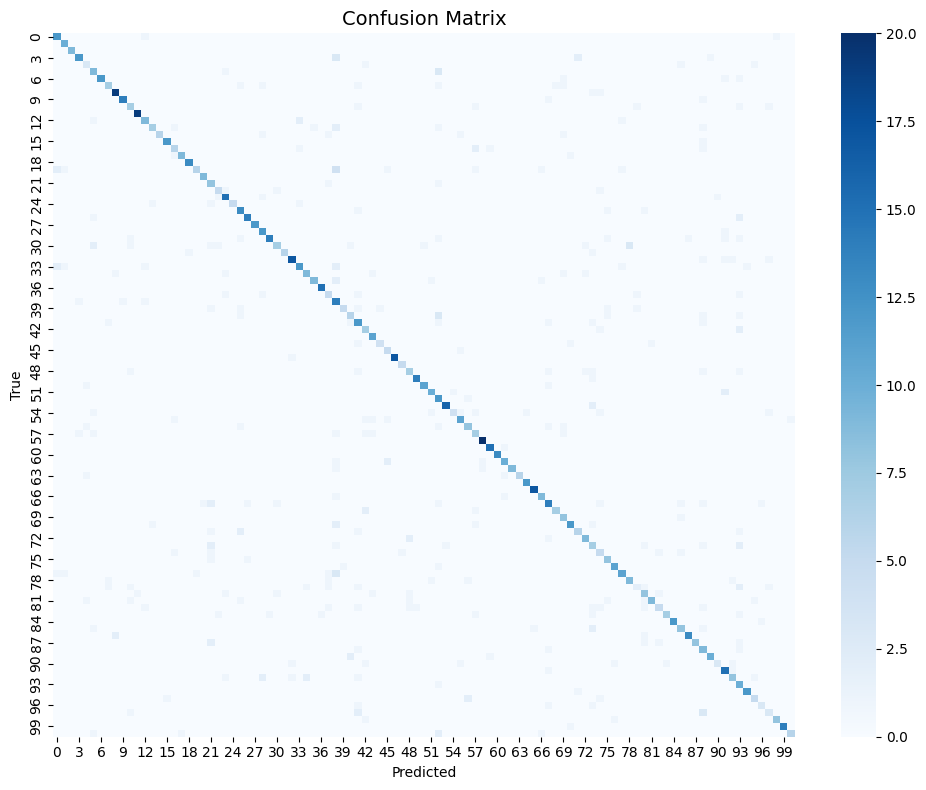

In [33]:
# ============================================================
# 2. Confusion Matrix Heatmap (IEEE quality)
# ============================================================
cm = confusion_matrix(yt, yp)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", annot=False, cbar=True)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

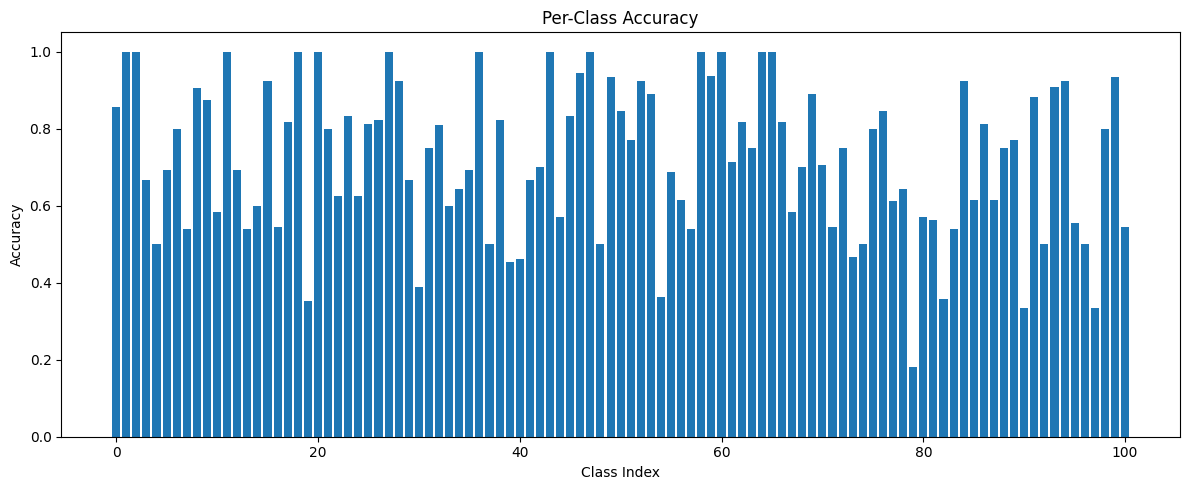

In [34]:
# ============================================================
# 3. Per-Class Accuracy Bar Chart
# ============================================================
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12,5))
plt.bar(range(cfg.N_CLASSES), class_acc)
plt.title("Per-Class Accuracy")
plt.xlabel("Class Index")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("per_class_accuracy.png", dpi=300)
plt.show()

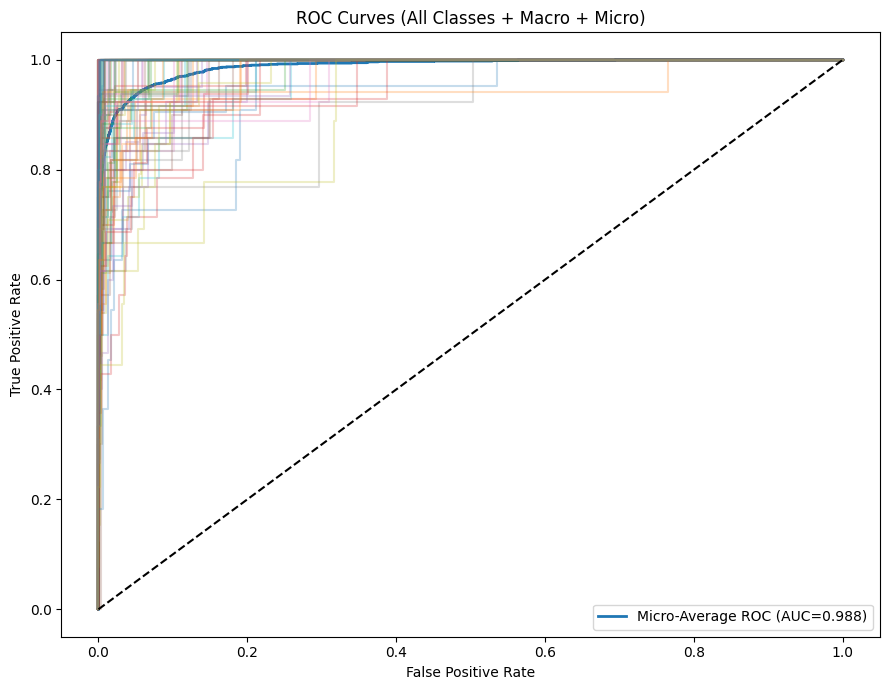

Macro AUC: 0.986
Micro AUC: 0.988


In [35]:
# ============================================================
# 4. ROC Curves for ALL classes + Macro + Micro
# ============================================================

plt.figure(figsize=(9,7))

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_oh.ravel(), yprobs.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, label=f"Micro-Average ROC (AUC={auc_micro:.3f})", linewidth=2)

# Macro-average ROC (mean of all class ROCs)
fpr_dict = {}
tpr_dict = {}
auc_dict = {}

for i in range(cfg.N_CLASSES):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_oh[:, i], yprobs[:, i])
    auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    plt.plot(fpr_dict[i], tpr_dict[i], alpha=0.25)

# Macro AUC
auc_macro = np.mean(list(auc_dict.values()))
plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curves (All Classes + Macro + Micro)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curves_all.png", dpi=300)
plt.show()

print(f"Macro AUC: {auc_macro:.3f}")
print(f"Micro AUC: {auc_micro:.3f}")

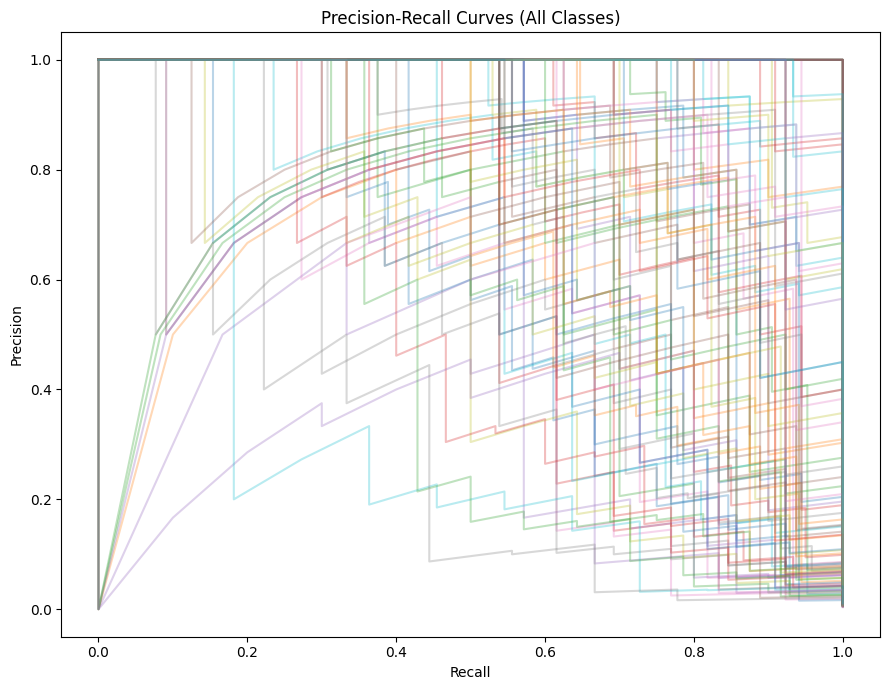

Macro PR AUC: 0.791


In [36]:
# ============================================================
# 5. Precision-Recall Curves for ALL classes + Macro
# ============================================================

plt.figure(figsize=(9,7))
pr_aucs = []

for i in range(cfg.N_CLASSES):
    precision, recall, _ = precision_recall_curve(y_true_oh[:, i], yprobs[:, i])
    pr_auc = auc(recall, precision)
    pr_aucs.append(pr_auc)
    plt.plot(recall, precision, alpha=0.3)

plt.title("Precision-Recall Curves (All Classes)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.savefig("precision_recall_all.png", dpi=300)
plt.show()

print(f"Macro PR AUC: {np.mean(pr_aucs):.3f}")

In [37]:
# ============================================================
# 6. Training Curves (loss + accuracy)
# ============================================================

# Only if history object exists
try:
    hist = history.history
    plt.figure(figsize=(10,4))
    plt.plot(hist['action_out_accuracy'], label='Train Accuracy')
    plt.plot(hist['val_action_out_accuracy'], label='Val Accuracy')
    plt.legend(); plt.title("Training Accuracy"); plt.tight_layout()
    plt.savefig("training_accuracy.png", dpi=300); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.legend(); plt.title("Training Loss"); plt.tight_layout()
    plt.savefig("training_loss.png", dpi=300); plt.show()
except:
    print("⚠ history not found. Accuracy/loss plots skipped.")

⚠ history not found. Accuracy/loss plots skipped.


In [ ]:
# Webcam inference for 32-frame sequence model
import cv2
import numpy as np
import keras
import time

# --- Config (edit if your model or input size differs) ---
MODEL_PATH = 'checkpoints/final_har_model.keras'  # change if your final model path is different
INPUT_SIZE = (224, 224)   # replace with your training input size if different
SEQUENCE_LENGTH = 32
class_labels = ["ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam", "BandMarching", "BaseballPitch", "Basketball", "BasketballDunk", "BenchPress", "Biking", "Billiards", "BlowDryHair", "BlowingCandles", "BodyWeightSquats", "Bowling", "BoxingPunchingBag", "BoxingSpeedBag", "BreastStroke", "BrushingTeeth", "CleanAndJerk", "CliffDiving", "CricketBowling", "CricketShot", "CuttingInKitchen", "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", "FloorGymnastics", "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", "HammerThrow", "Hammering", "HandstandPushups", "HandstandWalking", "HeadMassage", "HighJump", "HorseRace", "HorseRiding", "HulaHoop", "IceDancing", "JavelinThrow", "JugglingBalls", "JumpRope", "JumpingJack", "Kayaking", "Knitting", "LongJump", "Lunges", "MilitaryParade", "Mixing", "MoppingFloor", "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingCello", "PlayingDaf", "PlayingDhol", "PlayingFlute", "PlayingGuitar", "PlayingPiano", "PlayingSitar", "PlayingTabla", "PlayingViolin", "PoleVault", "PommelHorse", "PullUps", "Punch", "PushUps", "Rafting", "RockClimbingIndoor", "RopeClimbing", "Rowing", "SalsaSpin", "ShavingBeard", "Shotput", "SkateBoarding", "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", "SoccerPenalty", "StillRings", "SumoWrestling", "Surfing", "Swing", "TableTennisShot", "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", "Typing", "UnevenBars", "VolleyballSpiking", "WalkingWithDog", "WallPushups", "WritingOnBoard", "YoYo"]

# --- Load model (try safe load variations) ---
print('Loading model from', MODEL_PATH)
try:
    model = keras.models.load_model(MODEL_PATH)
except Exception as e:
    print('Standard load_model failed with:', e)
    try:
        # try with safe_mode=False (if present in your Keras build)
        model = keras.models.load_model(MODEL_PATH, safe_mode=False)
    except Exception as e2:
        print('Fallback load_model(s) failed:', e2)
        raise
print('Model loaded — input shape expected by model:', model.input_shape)

# --- Webcam capture ---
cap = cv2.VideoCapture(0)
frames = []
last_pred = ('', 0.0)
print("Press 'q' to quit")
while True:
    ret, frame = cap.read()
    if not ret:
        print('Webcam read failure — exiting')
        break
    # Preprocess
    img = cv2.resize(frame, INPUT_SIZE)
    img = img.astype('float32') / 255.0
    frames.append(img)
    if len(frames) > SEQUENCE_LENGTH:
        frames.pop(0)

    if len(frames) == SEQUENCE_LENGTH:
        input_seq = np.expand_dims(np.array(frames), axis=0)  # (1, 32, H, W, 3)
        preds = model.predict(input_seq, verbose=0)
        class_id = int(np.argmax(preds))
        label = class_labels[class_id]
        confidence = float(preds[0][class_id])
        last_pred = (label, confidence)
    else:
        label, confidence = last_pred

    # Overlay
    text = f"{label} ({confidence:.2f})" if label else 'Collecting...'
    cv2.putText(frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Action Recognition (32-frame)', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
